<a href="https://colab.research.google.com/github/hemo-n90/Project04/blob/master/notebooks/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2

# Задание



По заданию выбрать свои классы и обучить сверточную нейронную сеть из примера, используя GPU, а затем повысить точность модели. Провести три обучения для 3 разных тактик пуллинга: пуллинг с помощью шага свёртки stride, макс пуллинг, усредняющий пуллинг. Сравнить достигнутое качество, время обучения и степень переобучения. Выбрать лучшую конфигурацию. Сохранить модель. Перезапустить среду выполнения - теряются все текующие переменные.

Загрузить в colab готовую уже обученную на cifar100 модель. Преобразовать в onnx и сохранить локально.

Скачать [каталог](https://github.com/iu5git/Deep-learning/blob/main/ONNX_script) с html-файлом и встроить в него два файла моделей - обученную на ЛР1 и на ЛР2.

Скачать картинки из интернета согласно варианту и открыть их в html по кнопке. Автоматически в скрипте масштабируется изображение.

Выбрать в js нужные классы для готовой модели. Проверить на устойчивость обе модели, полносвязную и свёрточную, двигая картинку, убедиться в наличии свойства инвариантности сверточного слоя.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы, результаты работы модели ONNX в скрипте в браузере на загруженных изображениях, итоговую таблицу со результатами для всех вариантов обучения.

Варианты классов использовать из 1 лабораторной работы.

Дополнительно можно ознакомиться с визуализацией функции потерь Loss landscape

# Задания для самостоятельной работы
1. Проанализируйте результаты обучения вашей модели. Как изменилась точность на обучающей и тестовой выборке по сравнению с полносвязной моделью?
2. Измените вашу модель - сравните три варианта пуллинга по заданию. Сравните результаты обучения этих 3-ех вариантов
3. Измените вашу модель - поменяйте количество сверточных слоев, размер ядра свертки, шаг свертки и заполнение. Проанализируйте результаты обучения.
4. Возникает ли переобучение вашей модели?
5. Измените гиперпараметры обучения для повышения точности модели: количество эпох, размер батча, скорость обучения
6. Сравните полносвязную и сверточную нейронную сеть с помощью [визуализации](https://github.com/iu5git/Deep-learning/blob/main/ONNX_script). Сравните результаты моделей и их реакцию на сдвиги изображения. Укажите в отчете отличия моделей и поясните их.
7. Укажите, какие действия помогли повысить точность вашей модели и объясните почему.

# Контрольные вопросы для защиты
1. Сверточная нейронная сеть, объясните структуру, вычисления и назначение слоев и выполняемые преобразования.
2. Что такое свертка, размер ядра, шаг, заполнение? Объясните назначение.
3. Сравните количество нейронов, связей и параметров в полносвязной и сверточной нейронных сетях.
4. Объясните алгоритм оптимизации с моментом. В каких случаях применяется?
5. Свойства свертки

# Часть 1. Классификация изображений CIFAR100

## Импортирование необходимых библиотек

In [36]:
#!pip install torchsummary
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

## Определяем видеокарту GPU, чтобы на ней учить нейронную сеть

In [37]:
!nvidia-smi

Thu Dec 11 15:26:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             30W /   70W |     250MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Загрузка и распаковка набора данных CIFAR100

In [39]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2025-12-11 15:26:59--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.3’

cifar-100-python.ta 100%[===================>] 161.17M  35.4MB/s    in 5.0s    

2025-12-11 15:27:04 (32.4 MB/s) - ‘cifar-100-python.tar.gz.3’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## Чтение тренировочной и тестовой выборки

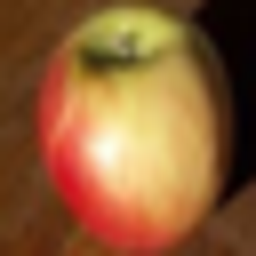

In [40]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')


CLASSES = [0, 55, 58]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [41]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e1418c2c050>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e1411d09d90>}

## Создание Pytorch модели сверточной нейронной сети

In [42]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 5, stride=4, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),#nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

HIDDEN_SIZE = 32
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
model

tensor([[0.1361, 0.1237, 0.1103]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         AvgPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
-------------------------------

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

## Выбор функции потерь и оптимизатора градиентного спуска

In [43]:
criterion = nn.CrossEntropyLoss()
# используется SGD c momentum
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

## Обучение модели по эпохам

  0%|          | 0/6000 [00:00<?, ?it/s]

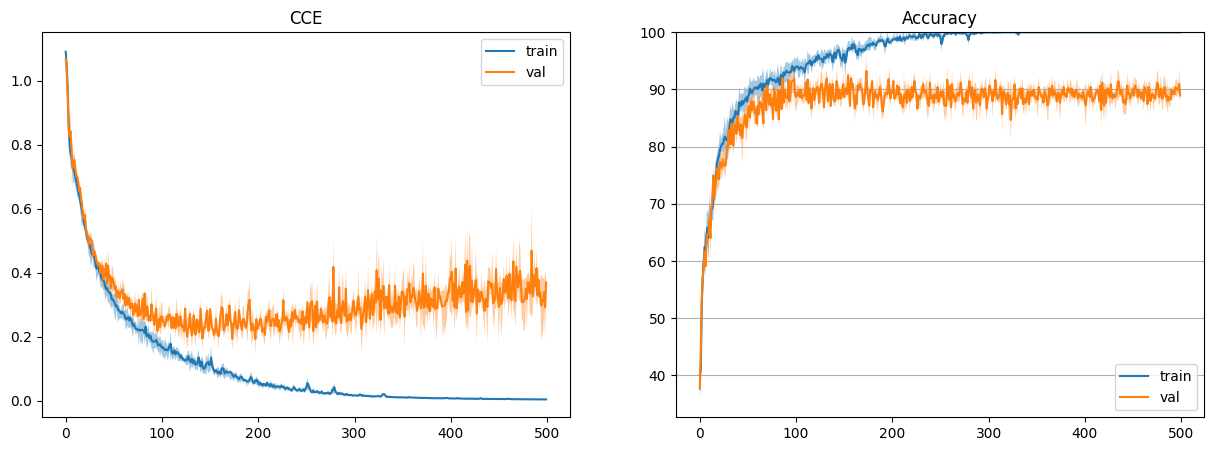

Обучение закончено за 36.3340265750885 секунд


In [44]:
EPOCHS = 500
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    #running_loss = 0.0
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        #running_loss += loss.item()
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    #running_loss = 0.0
    tmp = []
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            #running_loss += loss.item()
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

## Проверка качества модели по классам на обучающей и тестовой выборках

In [45]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       500
          55     1.0000    1.0000    1.0000       500
          58     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.9074    0.9800    0.9423       100
          55     0.8600    0.8600    0.8600       100
          58     0.9239    0.8500    0.8854       100

    accuracy                         0.8967       300
   macro avg     0.8971    0.8967    0.8959       300
weighted avg     0.8971    0.8967    0.8959       300

--------------------------------------------------


# Часть 2. Сохранение модели в ONNX

In [46]:

!pip install onnx onnxscript -q

import torch
import onnx

model.eval()

device = next(model.parameters()).device
print("Exporting from device:", device)

dummy_input = torch.randn(1, 32, 32, 3, device=device)

tmp_onnx = "cifar100_CNN_best_tmp.onnx"

torch.onnx.export(
    model,
    dummy_input,
    tmp_onnx,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],

)

print("Temporary ONNX saved to:", tmp_onnx)

model_onnx = onnx.load(tmp_onnx, load_external_data=True)
final_name = "cifar100_CNN_best_single.onnx"
onnx.save_model(model_onnx, final_name, save_as_external_data=False)

print("✅ Saved single-file ONNX model to:", final_name)


Exporting from device: cuda:0
[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Temporary ONNX saved to: cifar100_CNN_best_tmp.onnx
✅ Saved single-file ONNX model to: cifar100_CNN_best_single.onnx


In [47]:
!pip install onnx

In [48]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,
                  x,
                  "cifar100_CNN.onnx",
                  export_params=True,
                  opset_version=9,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

/tmp/ipython-input-4097618590.py:6: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model,               # модель
W1211 15:27:58.967000 745 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 9 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s31,32,32,3]>
            ),
            outputs=(
                %"output"<FLOAT,[1,3]>
            ),
            initializers=(
                %"seq.1.bias"<FLOAT,[32]>{TorchTensor(...)},
                %"seq.3.bias"<FLOAT,[64]>{TorchTensor(...)},
                %"seq.7.weight"<FLOAT,[3,256]>{TorchTensor(...)},
                %"seq.7.bias"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(Parameter containing: tensor([-0.3101,  0.8636, -0.4396], device='cuda:0', requires_grad=True), name='seq.7.bias')},
                %"seq.0.mean"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(tensor([0.5074, 0.4867, 0.4411], device='cuda:0'), name='seq.0.mean')},
                %"seq

# Loss landscape

## идея https://arxiv.org/abs/1712.09913

In [49]:
from copy import deepcopy
state_dict_backup = deepcopy(model.state_dict())

In [50]:
def generate_theta(seed=None):
    model.eval()
    model.load_state_dict(state_dict_backup)
    if seed is not None:
        np.random.seed(seed)
    params = []
    with torch.no_grad():
        for w in model.parameters():
            params.append(w.detach().cpu().numpy())
    params_n = np.concatenate([p.flatten() for p in params]).size
    random_theta_flat = np.random.normal(size=params_n)
    random_theta = []
    offset = 0
    for p in params:
        p_weights = p.flatten().size
        random_theta.append(random_theta_flat[offset:offset+p_weights].\
                            reshape(*p.shape))
        # normalization
        rank = random_theta[-1].shape.__len__()
        if rank == 4: # convolution
            #print('Conv')
            # Frobenius norm
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(*norm_p.shape, 1, 1)
        elif rank == 2: # fully connected
            #print('FC')
            norm_r = np.sqrt((random_theta[-1]**2).sum(axis=-1))
            norm_p = np.sqrt((p**2).sum(axis=-1))
            norm = (norm_p / norm_r).reshape(-1, 1)
        elif rank == 1: # bias
            #print('bias')
            norm_r = np.sqrt((random_theta[-1]**2).sum())
            norm_p = np.sqrt((p**2).sum())
            norm = norm_p / norm_r
        random_theta[-1] = random_theta[-1]*norm
        offset += p_weights
    assert offset==params_n, \
            "Not all params are utilized. Expected %d, found %d"%(params_n, offset)
    return random_theta

theta1 = generate_theta(seed=0)
theta2 = generate_theta(seed=1011)

In [51]:
criterion2 = nn.CrossEntropyLoss(reduction='none')
loss_curve = []
alphas = np.arange(-1500, 1500, step=5)/1000
for alpha in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new in zip(state_dict_backup.items(), theta1):
        tensor = v.clone().detach() + \
              alpha*(torch.tensor(v_new, device=device) - v.clone().detach())
        state_dict[k] = tensor
    model.load_state_dict(state_dict)
    loss = []

    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    loss_curve.append(np.concatenate(loss).mean())

  0%|          | 0/600 [00:00<?, ?it/s]

Text(0, 0.5, 'CCE, log10')

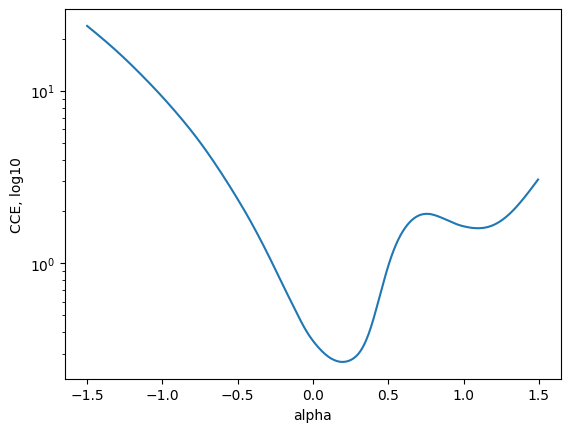

In [52]:
plt.plot(alphas, loss_curve)
plt.yscale('log')
plt.xlabel('alpha')
plt.ylabel('CCE, log10')

## 2D

In [53]:
# увеличив step, можно значительно ускорить вычисления
# однако вместе с этим теряется разрешение
alphas = []
vals = np.arange(-150, 151, step=5)/100
size = vals.size

# создаём заданный растр
for a1 in vals:
    for a2 in vals:
        alphas.append((a1, a2))

alphas = np.array(alphas)

In [54]:
Z = []
for a1, a2 in tqdm(alphas):
    state_dict = model.state_dict()
    for (k, v), v_new, v_new2 in zip(state_dict_backup.items(), theta1, theta2):
        # линейная интерполяция
        tensor = v.clone().detach() + \
                 a1*(torch.tensor(v_new, device=device) - \
                     v.clone().detach())
        # ещё раз со вторым вектором
        tensor = tensor + a2*(torch.tensor(v_new2, device=device) - tensor)
        state_dict[k] = tensor
        #print(k, tensor, v_new)
    model.load_state_dict(state_dict)
    loss = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).detach()#.cpu().numpy()
            loss.append(criterion2(outputs, labels).detach().cpu().numpy())
    Z.append(np.concatenate(loss).mean())
ZZ = np.array(Z)

  0%|          | 0/3721 [00:00<?, ?it/s]

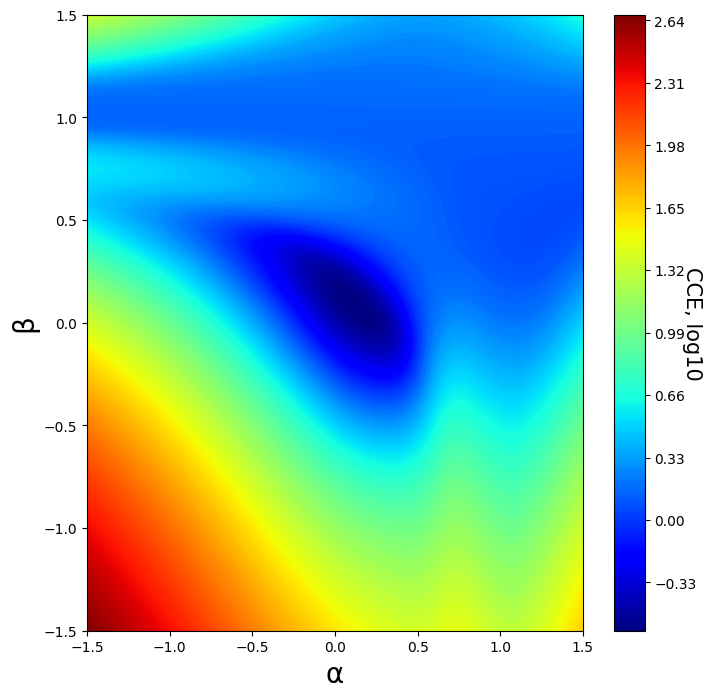

In [55]:
# настройка размера графика
plt.figure(figsize=(8, 8))
# отрисовка закрашенных контуров, аналогично 2 части 1 ЛР
cs = plt.contourf(alphas[:,0].reshape(size, size),
             alphas[:,1].reshape(size, size),
             np.log10(ZZ.reshape(size, size)),
             levels=255,
             cmap=plt.cm.jet,
             )
# установка цветовой шкалы и её названия
plt.colorbar(cs).ax.set_ylabel('CCE, log10', rotation=270, fontsize=15)
# установка названий осям X, Y
plt.xlabel('α', fontsize=20)
plt.ylabel('β', fontsize=20)
plt.show()

## 3D

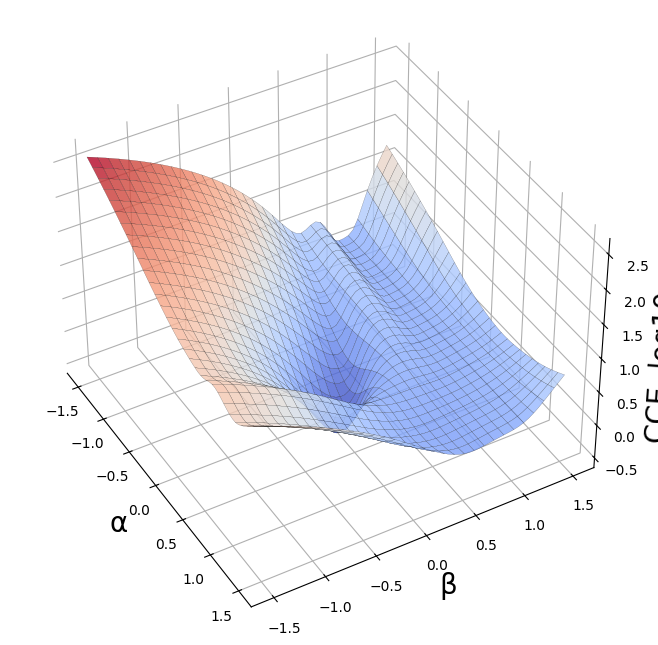

In [56]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})
# установка названий осям X, Y и Z
ax.set_xlabel('α', fontsize=20)
ax.set_ylabel('β', fontsize=20)
ax.set_zlabel('CCE, log10', fontsize=20)
# выставление прозрачности сетки, для красоты
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# отрисовка 3D поверхности, данные для отрисовки аналогичны contourf
surf = ax.plot_surface(alphas[:,0].reshape(size, size),
                       alphas[:,1].reshape(size, size),
                       np.log10(ZZ.reshape(size, size)),
                       cmap=plt.cm.coolwarm,
                       linewidth=0.1,
                       edgecolors='k',
                       alpha=0.8,
                       antialiased=True)
# первый агрумент - вращение вокруг XY, второрй аргумент - вокруг YZ
ax.view_init(40, -30)